<a href="https://colab.research.google.com/github/douglacardoso/whatsapp-group-analysis/blob/master/whatsapp_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Librarys

In [17]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re
import nltk
import pandas as pd
import numpy as np
import emoji
from collections import Counter
from PIL import Image
import random
plt.style.use('ggplot')

# 1. Loading text

In [18]:
# read text from file 
file_location = ('data/chat_tagarelas.txt')
with open(file_location, "r", encoding="utf-8") as f:
    data = f.read()
    data = ' '.join(data.split('\n'))

# 2. Manipulating
## 2.1. Creating a data frame

In [19]:
#separate user messages and datetime of the chat
pattern_1 = r'\d+/\d+/\d+,\s\d+[:]\d+\s\w+'
pattern_2 = r'\d+/\d+/\d+,\s\d+[:]\d+\s\w+\s\-'   

user_messages = re.split(pattern_2, data)[4:] # variable          
message_dates =  re.findall(pattern_1, data)[3:] # variable

# load user messages and dates into dataframe
df = pd.DataFrame({'user_message':user_messages, 'message_date': message_dates})

# convert message_date type
df['message_date'] = pd.to_datetime(df['message_date'], format='%m/%d/%y, %I:%M %p')

df.rename(columns={'message_date': 'date'}, inplace=True)

# print head 
df.head()

,user_message,date
0,"Guibs CCB POLITRECO: Eita, mais tagarelas",2021-01-15 23:27:00
1,Douglas Cardoso: <Media omitted>,2021-01-15 23:28:00
2,"Douglas Cardoso: roi, ou melhor, a paz de Deus",2021-01-15 23:29:00
3,Gabriel Novaes CCB IME: IRAAAAA,2021-01-15 23:30:00
4,Gabriel Novaes CCB IME: Amém,2021-01-15 23:30:00


## 2.2. Separete into columns

In [20]:
# separate users and messages 
users = []
messages = []
for message in df['user_message']:
    entry = re.split('([\w\W]+?):\s', message)
    if entry[1:]:
        users.append(entry[1])
        messages.append(entry[2])
    else:
        users.append('group_notification')
        messages.append(entry[0])

df['user'] =  users
df['message'] = messages
df.drop(columns=['user_message'], inplace=True)

df.tail()

,date,user,message
24910,2021-05-08 01:31:00,+55 13 99764-7677,<Media omitted>
24911,2021-05-08 01:31:00,+55 13 99764-7677,<Media omitted>
24912,2021-05-08 01:31:00,+55 13 99764-7677,<Media omitted>
24913,2021-05-08 01:31:00,+55 13 99764-7677,<Media omitted>
24914,2021-05-08 01:42:00,+55 11 97681-2408,😯


## 2.3. Numbers to Names

In [21]:
# remove spaces and mapping some users
# strip
df['user'] = [user.strip() for user in df['user']]

mapping_users = {'+55 19 98296-0425': 'Victor Scagion',
                 '+55 11 97173-7327': 'Julia Farma CCBUSP',
                 '+55 13 99764-7677': 'Felipe Monteiro',
                 '+55 11 96185-2730': 'Giuliana Piro',
                 '+55 11 94798-8115': 'Rodrigo Passos',
                 '+55 11 94271-3654': 'Rebecca Ferreira',
                 '+55 11 95006-1141': 'Danilo CCBUSP',
                 '+55 11 97681-2408': 'Maria Rueda'}

df['user'] = df['user'].replace(mapping_users)

## 2.4. Data cleaning

In [22]:
# 1. remove all the <Media omitted> messages
media = df[df['message'] == '<Media omitted> ']

print("Total number of Images + Videos Shared + Stickers: ", len(media))
df.drop(media.index, inplace=True)

# 2. remove all group notifications
notifications = df[df['user'] == 'group_notification']

print("Total Group Notifications: ", len(notifications))
df.drop(notifications.index, inplace=True)

# reset the index 
df.reset_index(inplace=True, drop=True)
df.tail()


Total number of Images + Videos Shared + Stickers:  2362
Total Group Notifications:  61


,date,user,message
22487,2021-05-08 00:48:00,Gabriel Novaes CCB IME,Iha
22488,2021-05-08 00:48:00,Gabriel Novaes CCB IME,Se prepara então fio
22489,2021-05-08 00:49:00,Gabriel Novaes CCB IME,Brincadeira gente
22490,2021-05-08 00:49:00,+55 11 96300-9194,Kkkkkkkk
22491,2021-05-08 01:42:00,Maria Rueda,😯


# 3. Who is most active in the group 

In [23]:
print("Amount of messages sent by user")

df.groupby('user')['message'].count().sort_values(ascending=False).head(10)

Amount of messages sent by user


user
Guibs CCB POLITRECO       2287
Victor Scagion            2149
Gabriel Novaes CCB IME    2145
Felipe Monteiro           1765
Raíssa CCB USP            1535
Julia Farma CCBUSP        1477
lionel                    1269
Danilo CCBUSP              673
Giuliana Piro              611
Maria Rueda                587
Name: message, dtype: int64

# 4. Frequently used emojis in the group

In [24]:
# init a Counter instance
emoji_counter = Counter()

# get all emojis in emoji package - language in english
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI['en'].keys())

# creating a regex compile with all emojis split by '|'
r = re.compile('|'.join(re.escape(p) for p in emojis_list))

# counting 
for index, row in df.iterrows():
    emojis_found = r.findall(row['message'])
    for emoji_f in emojis_found:
        emoji_counter[emoji_f] +=1

# show
for item in emoji_counter.most_common(10):
     print(f'{item[0]} - {item[1]}')


😂 - 1492
❤ - 313
🤣 - 295
🥺 - 272
🥳 - 264
🥰 - 210
🏻 - 178
🙏 - 165
🤩 - 156
😍 - 156


# 5. Sleep Cycles of the group

Text(0.5, 1.0, 'At what time do we talk most?')

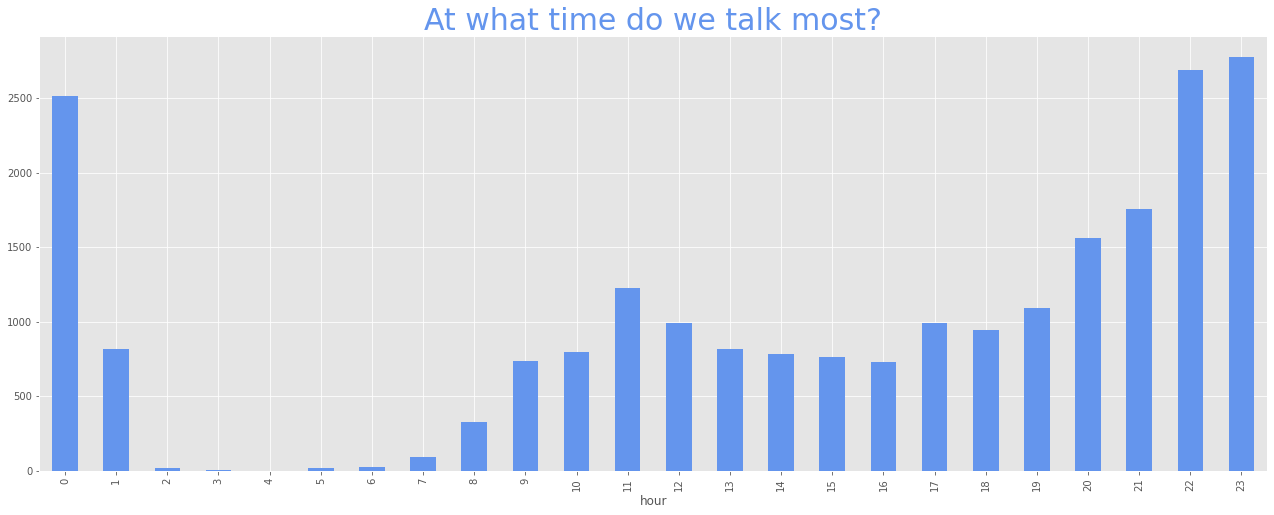

In [27]:
# creating a hour column 
df['hour'] = df['date'].apply(lambda x: x.hour)

# redefining columns order 
df = df[['date', 'hour', 'user', 'message']]

# plot 
df.groupby(['hour']).size().sort_index().plot(x="hour", kind='bar', figsize=(22,8), color='#6495ED')
plt.title('At what time do we talk most?', fontsize=30, color='#6495ED')

# 6. Word Cloud

In [10]:
# get an array from image.png
mask = np.array(Image.open('img/mask-cloud.png'))

In [11]:
# update stopwords 
stopwords = set(nltk.corpus.stopwords.words('portuguese'))
stopwords.update(['fui', 'sem', 'ei', 'fez', 'viu', 'estou', 'quero', 'ver', 'vou', 
                  'tenho', 'foi', 'ne', 'entao', 'então', 'assim', 'já', 'Gente', 
                  'essa', 'tá', 'ta', 'muito', 'e', 'é', 'quem', 'k', 'kk', 'kkk', 
                  'kkkk', 'kkkkk', 'q', 'pra', 'aí', 'bem', 'pq', 'tbm', 'Deu',
                  'acho', 'sim', 'tudo', 'vai', 'aqui', 'ser', 'dá', 'Ai', 'Aí',
                  'sei', 'ter', 'vcs','vc', 'Vc', 'lá'])

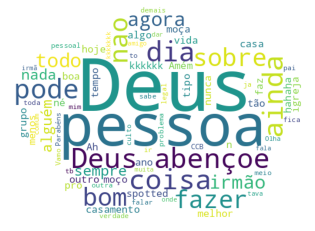

In [12]:
# join all messages in a unique string/text
all_summary = " ".join(word for word in df['message'].values)

# creating a wordcloud
wordcloud = WordCloud(background_color ='white', 
                stopwords = stopwords,
                mask = mask,
                min_font_size = 10)

# apply wordloud to text
wordcloud.generate(all_summary)

# plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.imshow(wordcloud)

## 6.1. Wordcloud custom color

In [13]:
# func for vari
def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(204, 50%%, %d%%)" % random.randint(10, 50)

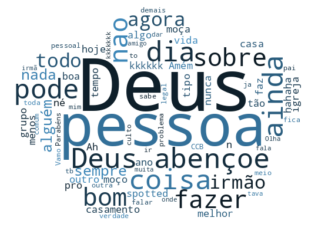

In [14]:
wc_blue = wordcloud.recolor(color_func=blue_color_func, random_state=3)

plt.imshow(wc_blue, interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
wc_blue.to_file('img/8-5-21.png')